# Tp3 Part 2: Minimum-time Optimal Control (due Nov 27)

In [1]:
import time
import numpy as np
from numpy.linalg import inv,norm,pinv,svd,eig
from scipy.linalg import solve_discrete_are
import matplotlib.pylab as plt
from copy import deepcopy
from tp3 import cartpole_loader
import pinocchio as pin
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
from utils.load_ur5_with_obstacles import load_ur5
import pinocchio.casadi as cpin
import casadi as cs

If importing load_ur5 fails, you may need to install the example-robot-data package in the conda environment of Tp2 and Tp3. This can be done by
```
conda install example-robot-data=4.3.0 -c conda-forge
```

In [2]:
# Load UR5 robot model
robot = load_ur5()
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [3]:
viz.viewer.jupyter_cell()

In [4]:
# Sample initial configuration and goal configuration
pin.seed(30)
q_initial = pin.randomConfiguration(robot.model)
viz.display(q_initial)

In [5]:
q_sample = pin.randomConfiguration(robot.model)
q_goal = q_initial + 0.5 * (q_sample - q_initial)
viz.display(q_goal)

### Ex: 3.2.1: Implement an acceleration-bounded minimum time optimal control problem

In [6]:
# Time-optimal point-to-point motion planning with joint acceleration inputs 

# Joint limits
q_min = robot.model.lowerPositionLimit
q_max = robot.model.upperPositionLimit
qdot_limit = robot.model.velocityLimit
q_acc_limit = 50 # joint acceleration limits (rad/s^2)

opti = cs.Opti()

N = 50
dt = opti.variable()  # time step (actually only almost time-optimal since dt is fixed for all time steps)
opti.set_initial(dt, 0.1)

q_traj = opti.variable(robot.model.nq, N+1)  # joint positions
qdot_traj = opti.variable(robot.model.nv, N+1)  #
qddot_control = opti.variable(robot.model.nv, N)  # joint accelerations (controls)

# Initial and final conditions
opti.subject_to(q_traj[:,0] == q_initial)
opti.subject_to(qdot_traj[:,0] == 0)
opti.subject_to(q_traj[:,-1] == q_goal)
opti.subject_to(qdot_traj[:,-1] == 0)

# Your code here
# Implement multiple-shooting Dynamics constraints (integration can be exact)
# Implement joint limit constraint, joint velocity limit constraint, joint acceleration limit constraint
# Minimize total time
# If you have trouble solving the problem, try to set initial guesses for the variables 

opti.minimize(dt * N)
opti.subject_to(dt >= 1e-2)

for k in range(N):
    # Get states at time step k and k+1
    q_k = q_traj[:, k]
    v_k = qdot_traj[:, k]
    a_k = qddot_control[:, k]
    q_k_next = q_traj[:, k + 1]
    v_k_next = qdot_traj[:, k + 1]
    
    # Dynamics constraints 
    opti.subject_to(q_k_next == q_k + v_k * dt + 0.5 * a_k * dt**2)
    opti.subject_to(v_k_next == v_k + a_k * dt)
    
    # Limit constraints
    opti.subject_to(opti.bounded(q_min, q_k, q_max))
    opti.subject_to(opti.bounded(-qdot_limit, v_k, qdot_limit))

# Initial guess for positions: linear interpolation between initial and goal configurations
for i in range(robot.model.nq):
    opti.set_initial(q_traj[i, :], np.linspace(q_initial[i], q_goal[i], N+1))

# Initial guess for velocities and accelerations
opti.set_initial(qdot_traj, 0)
opti.set_initial(qddot_control, 0)

In [7]:
opti.solver('ipopt', {'expand':True})
sol = opti.solve()
print("Optimal time:", sol.value(dt) * N)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     2724
Number of nonzeros in inequality constraint Jacobian.:      601
Number of nonzeros in Lagrangian Hessian.............:      601

Total number of variables............................:      913
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      624
Total number of inequality c

In [8]:
q_traj_opt = sol.value(q_traj)
v_traj_opt = sol.value(qdot_traj)
a_traj_opt = sol.value(qddot_control)
dt_opt = sol.value(dt)

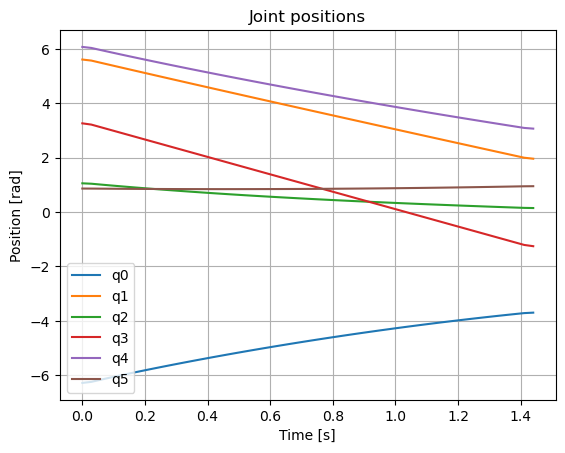

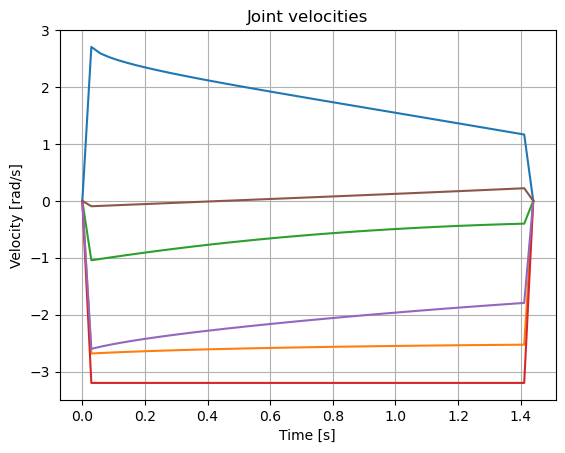

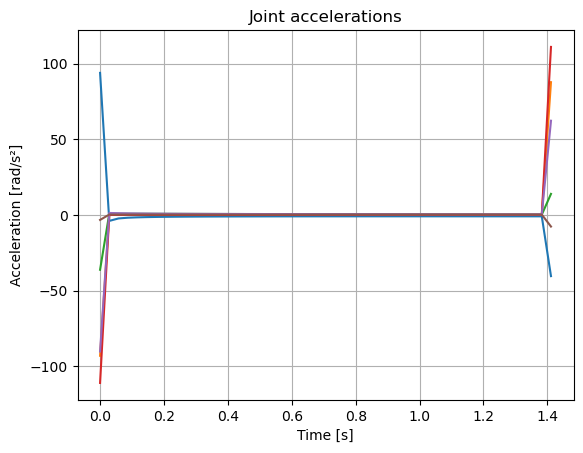

In [9]:
plt.figure()
plt.plot(np.arange(N+1)*dt_opt, q_traj_opt.T)
plt.title("Joint positions")
plt.xlabel("Time [s]")
plt.ylabel("Position [rad]")
plt.legend([f"q{i}" for i in range(robot.model.nq)])
plt.grid()
plt.figure()
plt.plot(np.arange(N+1)*dt_opt, v_traj_opt.T)
plt.title("Joint velocities")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [rad/s]")
plt.grid()
plt.figure()
plt.plot(np.arange(N)*dt_opt, a_traj_opt.T)
plt.title("Joint accelerations")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [rad/s²]")
plt.grid()
plt.show()

In [10]:
viz.viewer.jupyter_cell()

In [11]:
for k in range(N+1):
    viz.display(q_traj_opt[:,k])
    time.sleep(dt_opt)

In [12]:
# Get Casadi compatible model and data
cmodel = cpin.Model(robot.model) 
cdata = cmodel.createData()

q_sym = cs.SX.sym("q", robot.model.nq)
qdot_sym = cs.SX.sym("qdot", robot.model.nv)
qddot_sym = cs.SX.sym("qddot", robot.model.nv)
tau_sym = cpin.rnea(cmodel, cdata, q_sym, qdot_sym, qddot_sym)
rnea_fun = cs.Function("rnea_casadi", [q_sym, qdot_sym, qddot_sym], [tau_sym])

torque_limit = robot.model.effortLimit*0.5

tau_traj = []

# impose torque limits and store the torques in tau_traj
for k in range(N):
    # Get states at time step k
    q_k = q_traj[:, k]
    v_k = qdot_traj[:, k]
    a_k = qddot_control[:, k]
    
    # Compute Inverse Dynamics (Torque) at time step k
    tau_k = rnea_fun(q_k, v_k, a_k)
    tau_traj.append(tau_k)
    
    # Apply torque limits
    opti.subject_to(opti.bounded(-torque_limit, tau_k, torque_limit))

# We use previously found optimal solution as initial guess to ensure feasibility
opti.set_initial(q_traj, q_traj_opt)
opti.set_initial(qdot_traj, v_traj_opt)
opti.set_initial(qddot_control, a_traj_opt)

In [13]:
sol = opti.solve()
q_traj_opt = sol.value(q_traj)
v_traj_opt = sol.value(qdot_traj)
a_traj_opt = sol.value(qddot_control)
tau_traj_opt = sol.value(cs.hcat(tau_traj))
dt_opt = sol.value(dt)
print("Optimal time with torque limits:", dt_opt * N)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     2724
Number of nonzeros in inequality constraint Jacobian.:     5551
Number of nonzeros in Lagrangian Hessian.............:     5301

Total number of variables............................:      913
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      624
Total number of inequality constraints...............:      901
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:      900
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0000000e+00 3.72e+02 5.01e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

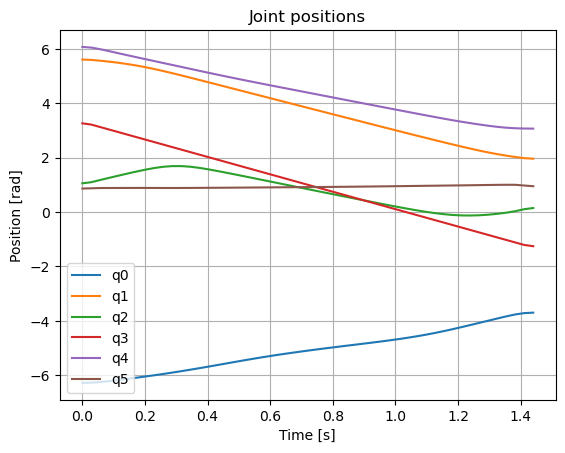

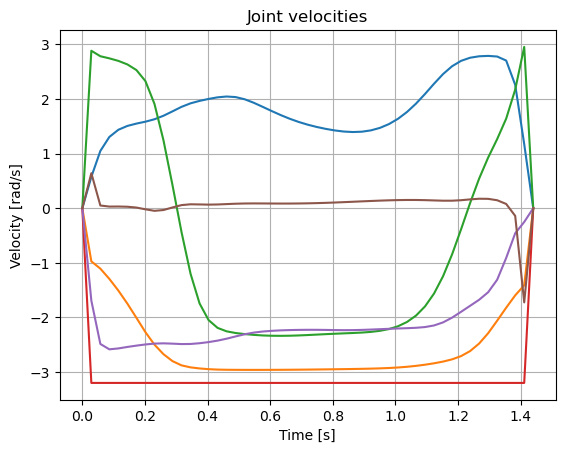

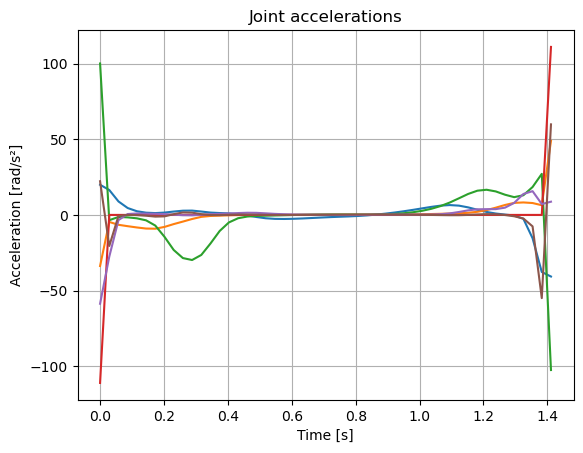

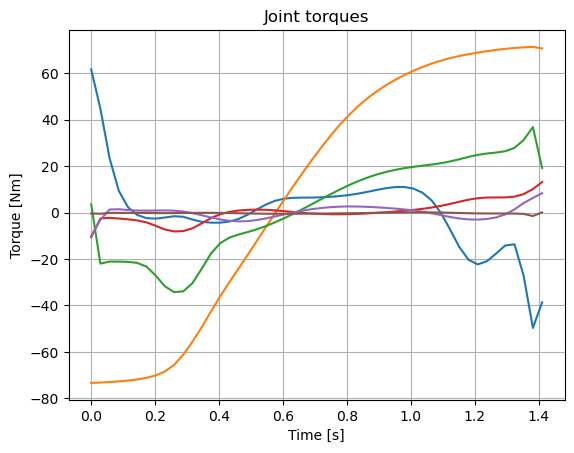

In [14]:
plt.figure()
plt.plot(np.arange(N+1)*dt_opt, q_traj_opt.T)
plt.title("Joint positions")
plt.xlabel("Time [s]")
plt.ylabel("Position [rad]")
plt.legend([f"q{i}" for i in range(robot.model.nq)])
plt.grid()
plt.show()  
plt.figure()
plt.plot(np.arange(N+1)*dt_opt, v_traj_opt.T)
plt.title("Joint velocities")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [rad/s]")
plt.grid()
plt.figure()
plt.plot(np.arange(N)*dt_opt, a_traj_opt.T)
plt.title("Joint accelerations")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [rad/s²]")
plt.grid()
plt.figure()
plt.plot(np.arange(N)*dt_opt, tau_traj_opt.T)
plt.title("Joint torques")
plt.xlabel("Time [s]")
plt.ylabel("Torque [Nm]")
plt.grid()
plt.show()

Do the control signals look satisfactory? If not, explain why not and how it can be improved?

$\textbf{\green{Answer}}$: No, the control signals are not satisfactory for a real physical robot. While mathematically optimal for the constraints given, the signals will cause abrupt switches between some values, especially at the start and end of the trajectory for the acceleration. In practice, this would only damage the robot hardware, applying too much mechanical stress and being problematic because physical actuators have limited bandwidth and cannot change force instantaneously. 

To improve the control signals, we could add a regularization term to not only minimize the time, but also penalize bad behavior by adding, for example, a weight on the squared acceleration. We could also add constraints to limit the rate of changes of the torque or the acceleration to generate smoother trajectories.